In [441]:
%matplotlib inline
from pylab import *

import shutil
import sys
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.optimize import minimize
import itertools
import pyomo.environ as env
import ast
from pyomo.environ import *
#solver = env.SolverFactory("ipopt")

import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [442]:
import watertap as wt

In [443]:
#### MODEL FUNCTIONS ####

In [595]:
# LINKS COMING OUT OF SOURCE NODE AND GOING INTO FIRST UP MUST EQUAL FEEDWATER TOTAL! 
def source_flow_constraint(m, source_node): #RENAME THIS CONSTRAINT
    inflow_link_list = [];

    for inflow_link in T.out_edges(source_node): # TO DO MAKE FUNCTION
        inflow_link_list.append(T.edges[inflow_link]['name'])
    
    flow_in = T.nodes[source_node]['Flow'] #something funky with dictionary setting here - why no .Value?
        
    return sum(m.FlowInLinkSegments[e] for e in inflow_link_list) == flow_in

In [596]:
def source_recycle_flow_constraint(m, source_node): #RENAME THIS CONSTRAINT --> JUST SETTING INFLOW
    inflow_link_list = [];

    for inflow_link in T.out_edges(source_node): # TO DO MAKE FUNCTION
        inflow_link_list.append(T.edges[inflow_link]['name'])
            
    return sum(m.RecycleFlowInLinkSegments[e] for e in inflow_link_list) == 0

In [597]:
# CHANGE THIS FOR ALL NODES THAT HAVE INFLOWS AND OUTFLOWS
def node_mass_balance_constraint(m, node):
        
    flow_in = 0
    for i in T.in_edges(node):
        flow_in = flow_in + m.FlowInLinkSegments[T.edges[i]['name']] #+ m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    flow_out = 0
    for i in T.out_edges(node):
        flow_out = flow_out + m.FlowInLinkSegments[T.edges[i]['name']] #+ m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [598]:
# CHANGE THIS FOR ALL NODES THAT HAVE INFLOWS AND OUTFLOWS
def node_recycle_mass_balance_constraint(m, node):
        
    flow_in = 0
    for i in T.in_edges(node):
        flow_in = flow_in + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    flow_out = 0
    for i in T.out_edges(node):
        flow_out = flow_out + m.RecycleFlowInLinkSegments[T.edges[i]['name']] 

    return (-0.000000001, flow_in - flow_out, 0.000000001)

In [599]:
# recovered stream of only source water
def calculate_recovered_streams(m, link):
    if 'treated' in link:
        print('treated:', link)
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
        source_inflow, recycled_inflow  = calculate_up_inflow(m, unit_process)
        sum_of_up_inflow = source_inflow + recycled_inflow
        
        return m.FlowInLinkSegments[link] == sum_of_up_inflow * T.nodes[unit_process]['recovery_factor']
    
    else: return Constraint.Skip

In [600]:
# recovered stream of only source water --> RENAME THIS TO FINAL STREAM
def recycle_streams_constraint(m, link):
    if 'recycle' not in link: return m.RecycleFlowInLinkSegments[link] <= 0.00000001
    if 'recycle' in link: 
        if 'source_and_recycle_stream' not in link:
            return m.FlowInLinkSegments[link] <= 0.00000001
        else: return Constraint.Skip
        

In [601]:
# waste stream from unit process
def calculate_waste_streams(m, link):
    if 'waste' in link:
        print('waste:', link)
        unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
        source_inflow, recycled_inflow = calculate_up_inflow(m, unit_process)

        return m.FlowInLinkSegments[link] == source_inflow * T.nodes[unit_process]['waste_factor']

    else: return Constraint.Skip

In [602]:
# recycle stream from unit process
def calculate_recycle_streams(m, link):
    if 'recycle' in link:
        if 'source_and_recycle_stream' not in link:
            unit_process = wt.get_graph_chars.get_link_df(T).loc[link][0] #change column names for df so easier to follow
            source_inflow, recycled_inflow = calculate_up_inflow(m, unit_process)

            return m.RecycleFlowInLinkSegments[link] == source_inflow * T.nodes[unit_process]['recycle_factor']
        else: return Constraint.Skip
    else: return m.RecycleFlowInLinkSegments[link] == 0

In [603]:
# inflow to unit process
def calculate_up_inflow(m, unit_process):
        # equation for sum of inflows -> MAKE THIS A FUNCTION?!?!
    inflow_links = []
    for inflow_link in T.in_edges(unit_process):
        inflow_links.append(T.edges[inflow_link]['name'])   
    
    source_inflow = 0; recycled_inflow = 0;
    
    source_inflow = sum(m.FlowInLinkSegments[link] for link in inflow_links) 
    recycled_inflow = sum(m.RecycleFlowInLinkSegments[link] for link in inflow_links) 
    
    return source_inflow, recycled_inflow

In [604]:
#THIS IS FOR END NODE!!!!! BETTER NAMING NEEDED FOR FUNCTIONS
def calculate_recovered_water(m, end_node): # AT NODE

    recovered_flow = 0; # CAN DO SUM INSTREAD with list of nodes/links? outflow_link_list = []; 

    for up_outflow_link in T.in_edges(end_node): # TO DO MAKE FUNCTION
        #outflow_link_list.append(G.edges[outflow_link]['name'])
    
        recovered_flow = recovered_flow + m.FlowInLinkSegments[T.edges[up_outflow_link]['name']]
    
    return model.RecoveredFlow[end_node] == recovered_flow

In [605]:
def set_inflow_BOD_values(m, inlet_link_to_process):
    
    source_node_for_stream = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][0]
    BOD_value = T.nodes[source_node_for_stream]['BOD'].Value
    
    #JUST SET IT EQUAL TO THE VALUE AT THE SOURCE NODE
    return m.BODInLinkSegments[inlet_link_to_process] == BOD_value

#def set_inflow_TOC_values(m, inlet_link_to_process):
    
#    source_node_for_stream = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][0]
#    TOC_value = T.nodes[source_node_for_stream]['TOC'].Value
    
    #JUST SET IT EQUAL TO THE VALUE AT THE SOURCE NODE
#    return m.TOCInLinkSegments[inlet_link_to_process] == TOC_value

In [606]:
# TODO WILL THIS CREATE A PROBLEM IN NOT RECALCULATING TREATMENT TO CERTAIN STANDARD?
# SHOULD THIS BE AN EQUATION? LIKELY NOT HERE -> EQUATIONS AT NODE THAT AFFECT OUTFLOW PARAMETERS
# THIS IS BASED ON NODES BUT CAN/SHOULD IT BE BASED ON LINKS GOING INTO THE NODE?!

def apply_BOD_inlet_constraint(m, inlet_link_to_process): # BASED ON UP CHARS
    
    process_name = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][1]
    source_node_for_stream = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][0]
    #BOD_value = T.nodes[source_node_for_stream]['BOD'] DELETE?
    
    if T.nodes[source_node_for_stream]['BOD'].Value > T.nodes[process_name]['BOD_constraint']:
        return m.FlowInLinkSegments[inlet_link_to_process] == 0 # BOD must be lower than constraint otherwise 0 flow in
    else: 
        return Constraint.Skip

def apply_TOC_inlet_constraint(m, inlet_link_to_process): # BASED ON UP CHARS
    
    # APPLY ALL CONSTRAINTS UNLESS A CONSTRAINT IS SET TO OFF SOMEWHERE      
    process_name = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][1]
    source_node_for_stream = wt.get_graph_chars.get_link_df(T).loc[inlet_link_to_process][0]
    
    if T.nodes[source_node_for_stream]['TOC'].Value > T.nodes[process_name]['TOC_constraint']:
        return m.FlowInLinkSegments[inlet_link_to_process] == 0
    else: 
        return Constraint.Skip   

adding unit process to network: microfiltration_a
adding unit process attributes: microfiltration_a


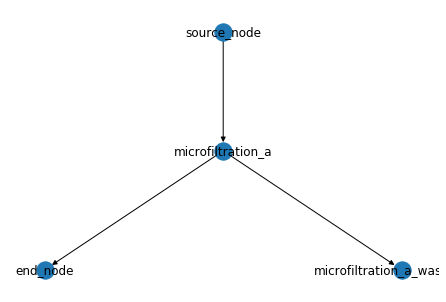

In [607]:
# imports all trains from library/unit processes
unit_process_name_list = [wt.unit_process_library_list[0]] #wt.unit_process_library_list #[wt.unit_process_library_list[0]]

# FROM AND TO PROCESS TO BE CHANED TO SINGLE VS TRAIN OPTION - HAVE TWO OPTIONS. START WITH TRAIN.
T = wt.treatment_train_design.create_train(unit_process_name_list=unit_process_name_list,  # OLDER VERSION HAD TO AND FROM PROCESS BUT THAT IS FOR ADDING ONE PROCESS AT A TIME
                                            source_water_reference = 'Poseidon',
                                            source_water_type = 'Wastewater',
                                            source_water_case_study ='Typical untreated domestic wastewater',
                                            enduse_water_reference = 'Poseidon',
                                            enduse_water_type = 'Environmental',
                                            enduse_water_case_study = 'EPA: Environmental Reuse',
                                            flow = 1000.0)

wt.display.treatment_train_graph(T)

In [608]:
#recycle flow fraction could be defined from part of waste stream or based on UP chars (UP chars for now)
# how to apply to multiple streams?
#wt.treatment_train_design.
T = wt.treatment_train_design.add_recycle_stream(T,
                       from_unit_process = 'microfiltration_a',
                       to_unit_process = 'microfiltration_a',
                       recyle_fraction_of_waste = 1,
                       number_of_affected_streams = 1) #

updating unit process attributes: microfiltration_a


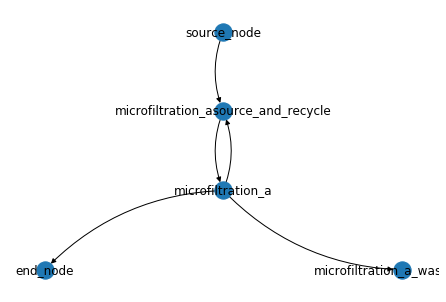

In [609]:
wt.display.treatment_train_graph(T, with_recycle = True)

In [610]:
# EXTRA CAPABAILITIES ------ (MOSTLY COMPLETED) ---- NEED TO MOVE TO A MODULE 'treatment_train_design.edit.remove OR .add'

# REMOVE ONE OR PROCESSES IF NEEDED
#T = wt.filter_processes.remove(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_single_processes(T, process_name = 'microfiltration_a')
#T = wt.filter_processes.select_multiple_processes(T, process_name_list = ['microfiltration_a', 'ultrafiltration_a'])

### ADD ANOTHER UNIT PROCESS?!?!?!?!?!?!

# NEED TO FIX ISSUE WITH IMPORTING MULTIPLE FEEDWATER DATA/SOURCES -> SHOULD NO LONGER BE BASED ON FEEDWATER DATA.
# ADD ANOTHER SOURCE WATER
#T, feedwater_data = wt.create_treatment_train.add_multiple_water_sources(T,
#                               feedwater_data,
#                               number_of_additional_sources = 1, 
#                               source_to_node_names=[['source_a', wt.unit_process_library_list[0]]],
#                               constituents = 'dummy_name',
#                               from_case_study = True,
#                               flows = [[500]])

# ADD ANOTHER END USE NODE
#T = wt.create_treatment_train.add_multiple_end_uses(T,
#                               number_of_additional_nodes = 1, 
#                               source_to_node_names=[[wt.unit_process_library_list[0], 'end_a']],
#                               constituent_constraints = 'dummy_name',
#                               from_case_study = True,
#                               min_flows = [[0]])


# IMPORT FEEDWATER DATA ----> NOT NEEDED ANYMORE TO RUN MODEL ----> BUT GOOD CAPABILITY TO HAVE
#fw_filename = 'case_study_water_sources_and_uses.csv'
#feedwater_data = wt.importfile.feedwater(input_file = fw_filename,
#                                         reference = 'Poseidon',
#                                         case_study = 'Typical untreated domestic wastewater',
#                                         water_type = 'Wastewater',
#                                         source_or_use = 'Source')

#feedwater_data


In [611]:
## TO DO IMMEDIATE:
# FEEDWATER DATA CAN BE IF SOMEONE WANTS TO UPLOAD NEW!??

In [612]:
model = env.ConcreteModel()
model.LinkSet = env.Set(initialize=wt.get_graph_chars.get_link_list(T)) # all links in network
model.UnitProcesses = env.Set(initialize=unit_process_name_list) # all unit processes
model.SourceNodes = env.Set(initialize=wt.get_graph_chars.get_source_nodes(T)) # all source nodes
model.RecoveredWaterNodes = env.Set(initialize=wt.get_graph_chars.get_recovered_water_nodes(T)) # all recovered water nodes

model.AllNoneSourceEndNodes = env.Set(initialize=wt.get_graph_chars.get_all_none_source_end_nodes(T))

#inflow links to UPs
model.UnitInflowLinkSet = env.Set(initialize=wt.get_graph_chars.get_inflow_links(T, unit_process_name_list))

# flow in and out of processes
model.FlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
model.RecycleFlowInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
# final recovered flow
model.RecoveredFlow = env.Var(model.RecoveredWaterNodes, bounds=(0,None))

#create variables for constituents in and out of processes
#model.BODInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))
#model.TOCInLinkSegments = env.Var(model.LinkSet, bounds=(0,None))


In [613]:
model.CalculateRecoveredFlows = env.Constraint(model.LinkSet, rule=calculate_recovered_streams)

treated: microfiltration_a_treated_stream


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


In [614]:
model.CalculateRecycleRecoveredFlows = env.Constraint(model.LinkSet, rule=recycle_streams_constraint)

In [615]:
model.CalculateWasteFlows = env.Constraint(model.LinkSet, rule=calculate_waste_streams)

waste: microfiltration_a_waste_stream


/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


In [616]:
model.CalculateRecycleFlows = env.Constraint(model.LinkSet, rule=calculate_recycle_streams)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.
/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # This is added back by InteractiveShellApp.init_path()


In [617]:
#model.CalculateRecycleInFlows = env.Constraint(model.LinkSet, rule=calculate_recycle_inflow)

In [618]:
#model.CalculateRecWasteMax = env.Constraint(model.UnitProcesses, rule=calculate_recycle_waste_max)

In [619]:
# set constituents in inflow streams
#model.SetInflowBODValues = env.Constraint(model.UnitInflowLinkSet, rule=set_inflow_BOD_values)
#model.SetInflowTOCValues = env.Constraint(model.UnitInflowLinkSet, rule=set_inflow_TOC_values)


In [620]:
# Apply constituents inlet constraint
#model.BODInletConstraint = env.Constraint(model.UnitInflowLinkSet, rule=apply_BOD_inlet_constraint)
#model.TOCInletConstraint = env.Constraint(model.UnitInflowLinkSet, rule=apply_TOC_inlet_constraint)

In [621]:
# Equations for mass balance
model.NodeMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, rule=node_mass_balance_constraint)

In [622]:
model.NodeRecycleMassBalanceConstraint = env.Constraint(model.AllNoneSourceEndNodes, 
                                                 rule=node_recycle_mass_balance_constraint)

In [623]:
# Makes sure inlet streams add up to feedwater volume
model.CheckUnitInletRecycleFlows = env.Constraint(model.SourceNodes, rule=source_flow_constraint)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  # Remove the CWD from sys.path while we load stuff.


In [624]:
model.CheckUnitInletFlows = env.Constraint(model.SourceNodes, rule=source_recycle_flow_constraint)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  import sys


In [625]:
# Equations for outlet flows
#model.CalculateFlows = env.Constraint(model.LinkSetUPOut, rule=calculate_out_flows)

In [626]:
# Calculate recovered water
model.CalculateRecoveredWater = env.Constraint(model.RecoveredWaterNodes, rule=calculate_recovered_water)

In [627]:
model.objective_function = env.Objective(
    #expr=sum(model.FlowInLinkSegments[x] for x in model.LinkSet), # max flows all links -> simulation
    expr=sum(model.RecoveredFlow[x] for x in model.RecoveredWaterNodes), # can do this for node?
    sense=env.maximize)

solver = env.SolverFactory("ipopt")
solver.solve(model)

/Users/amiara/miniconda3/envs/water-hubv2/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


    model=unknown;
        message from solver=Ipopt 3.12.12\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 17, 'Number of variables': 11, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.12.12\\x3a Converged to a locally infeasible point. Problem may be infeasible.', 'Termination condition': 'infeasible', 'Id': 200, 'Error rc': 0, 'Time': 0.12582802772521973}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [628]:
for x in model.LinkSet:
    print(x, ':', round(env.value(model.FlowInLinkSegments[x]), 2))

microfiltration_a_source_stream : 1000.0
microfiltration_a_treated_stream : 999.01
microfiltration_a_waste_stream : 0.44
microfiltration_a_recycle_stream : 0.0
microfiltration_a_source_and_recycle_stream : 1000.0


In [629]:
for x in model.LinkSet:
    print(x, ':', round(env.value(model.RecycleFlowInLinkSegments[x]), 2))

microfiltration_a_source_stream : 0.0
microfiltration_a_treated_stream : 0.0
microfiltration_a_waste_stream : 0.0
microfiltration_a_recycle_stream : 50.0
microfiltration_a_source_and_recycle_stream : 50.0


In [ ]:
##### MAYBE CODES #####

In [ ]:
def add_unit_process(G, unit_process_name='unit_process', from_process_lib='False',
                    from_process='None', to_process='None'):
    print('adding unit process', unit_process_name)
    
    G.add_edges_from([('source_node', unit_process_name, {'name': 'source_stream'}), 
                      (unit_process_name, 'end_node', {'name': 'treated_stream'})])
    
    #add option to read in multiple from and to
    #add option to import for existing list if from_process_lib is true
    
    return G

In [ ]:
feedwater = dict()
for row in range(0, len(feedwater_data)):
    feedwater[feedwater_data.Variable[row]] = feedwater_data.Value[row]